In [1]:
#Dependencies
#matplotlib for graphics
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
#numpy for calc
import numpy as np
import pandas as pd

In [3]:
#datetime for real-time analysis
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy as sa
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
#Database engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

            Precipitation
Date                     
2016-08-23           0.00
2016-08-24           0.08
2016-08-25           0.08
2016-08-26           0.00
2016-08-27           0.00


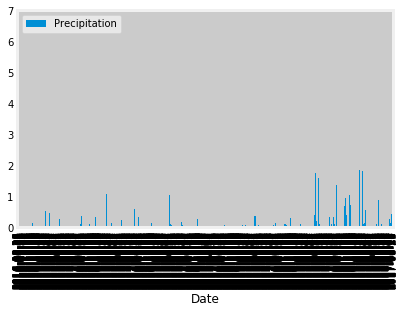

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# List Capture
end_date="2017-08-23"
start_date="2016-08-23"
measurement_date = []
precip = []

# Query to retrieve the data and precipitation scores
for row in session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date<=end_date,Measurement.date>= start_date).all(): #1 year of data
    #print(row)
    measurement_date.append(row[0])
    precip.append(row[1])
    
#print(measurement_date)
#print(precip)

#Query results to Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame({'Date':measurement_date,'Precipitation':precip})
precip_df.set_index('Date',inplace = True)

print(precip_df.head())

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot.bar()
#plt.tight_layout()
plt.show()

In [12]:
![precipitation](Images/precipitation.png)

'[precipitation]' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
station_query = session.query(Measurement.station).all()
#station_query[0:5]
len(set(station_query))

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = np.array(station_query)
unique_element, counts_elements = np.unique(active_station,return_counts=True)
#print(unique_element)
#print(counts_elements)
#print(np.asarray(unique_element,counts_elements))
station_count_df = pd.DataFrame({"Station":unique_element,"Count":counts_elements})
station_count_df.sort_values(by='Count',ascending = False, inplace = True)
indexed_station = station_count_df.set_index("Station")
print(indexed_station)

             Count
Station           
USC00519281   2772
USC00519397   2724
USC00513117   2709
USC00519523   2669
USC00516128   2612
USC00514830   2202
USC00511918   1979
USC00517948   1372
USC00518838    511


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
max_count = indexed_station.max()
#print(max_count) #max count to be referenced in index df
most_active = list(np.where(indexed_station["Count"] == max_count[0]))
station_max_active = indexed_station.iloc[most_active[0]]
max_station = str(station_max_active.index[0])
#max_station #prints station with largest observations

#query based on max_station
temp = session.query(Measurement.tobs).\
filter(Measurement.station == max_station).all()
#temp

#stats of the query
maxstation_maxtemp = np.max(temp)
maxstation_mintemp = np.min(temp)
maxstation_avgtemp = np.mean(temp)

print(f'{max_station} max temp: {maxstation_maxtemp}')
print(f'{max_station} min temp: {maxstation_mintemp}')
print(f'{max_station} avg temp: {maxstation_avgtemp}')

USC00519281 max temp: 85.0
USC00519281 min temp: 54.0
USC00519281 avg temp: 71.66378066378067


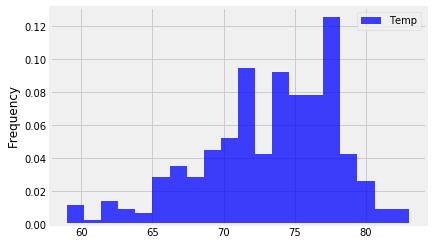

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_high = session.query(Measurement.date, Measurement.tobs).\
                filter(Measurement.date >= start_date).\
                filter(Measurement.station == max_station).all()
#print(station_high)
station_high_df = pd.DataFrame(np.array(station_high), columns = (["Date","Temp"]))
station_high_df.Temp = station_high_df.Temp.astype(float)
station_high_df.set_index("Date")
station_high_df.plot.hist(bins=20, density=1, facecolor='b', alpha=0.75)


![precipitation](Images/station-histogram.png)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2011-02-28'
end_date = '2012-02-23'
temp_query = calc_temps(start_date,end_date)
print(temp_query)

[(56.0, 72.79413946587538, 86.0)]


Average Temp: 72.79413946587538


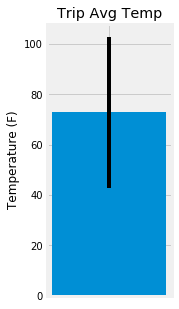

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg_t = temp_query[0][1]
max_t = temp_query[0][2]
min_t = temp_query[0][0]
print(f'Average Temp: {avg_t}')
plt.figure(figsize = (2,5))
plt.bar(1,avg_t, yerr=(max_t-min_t), tick_label = "")
plt.ylabel("Temperature (F)")
plt.title("Trip Avg Temp")
plt.show()

In [38]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
#Measurement
end_date="2017-08-23"
start_date="2016-08-23"
station1 = []
measurement_date = []
precip = []

# Query to retrieve the data and precipitation scores
for row in session.query(Measurement.station, Measurement.date, Measurement.prcp).\
filter(Measurement.date<=end_date,Measurement.date>= start_date).all(): #1 year of data
    #print(row)
    station1.append(row[0])
    measurement_date.append(row[1])
    precip.append(row[2])
   
#Station
station2 = []
name = []
lat = []
long = []
elev = []

#Query to retrieve data and other info. needed
for row in session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all():
    #print(row)
    station2.append(row[0])
    name.append(row[1])
    lat.append(row[2])
    long.append(row[3])
    elev.append(row[4])
    
#One Dataframe to bind them
measurement_df = pd.DataFrame({"Station":station,"Date":measurement_date,"Precipitation":precip})
station_df = pd.DataFrame({"Station":station2,"Name":name,"Latitude":lat,"Longitude":long,"Elevation":elev})
weather_df = pd.merge(measurement_df,station_df,on='Station')
#weather_df.head()

#Add a touch of Analysis
#individual avg stations
fork = weather_df.groupby("Station").mean()
fork.sort_values(by='Precipitation',ascending = False, inplace = True)

#full data
weather_df.sort_values(by='Precipitation',ascending = False, inplace = True)
#restructure the index
indexed_weather = weather_df.set_index("Station")

#print it
print(f"FULL DATA between {min_date} and {max_date}:")
print(indexed_weather.head())
print("--------------------------------------------------------------------")
print()
print(f'Average Per Station between {min_date} and {max_date}:')
print(fork)

FULL DATA between 2016-08-23 and 2017-08-23:
                   Date  Precipitation                                Name  \
Station                                                                      
USC00516128  2016-09-14           6.70        MANOA LYON ARBO 785.2, HI US   
USC00519523  2017-04-29           6.25  WAIMANALO EXPERIMENTAL FARM, HI US   
USC00519523  2017-02-11           5.04  WAIMANALO EXPERIMENTAL FARM, HI US   
USC00516128  2017-07-22           4.00        MANOA LYON ARBO 785.2, HI US   
USC00516128  2016-10-04           3.46        MANOA LYON ARBO 785.2, HI US   

             Latitude  Longitude  Elevation  
Station                                      
USC00516128  21.33310 -157.80250      152.4  
USC00519523  21.33556 -157.71139       19.5  
USC00519523  21.33556 -157.71139       19.5  
USC00516128  21.33310 -157.80250      152.4  
USC00516128  21.33310 -157.80250      152.4  
--------------------------------------------------------------------

Average Per Stat

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
